# Traffic Red-Light Running Violation Detection 🚦
This notebook demonstrates a system for detecting red light violations using computer vision and OCR (Optical Character Recognition). The system captures video frames, detects license plates, and reads the license plate numbers when a vehicle crosses a red light.


## Import Libraries
We start by importing the necessary libraries for image processing, OCR, and data handling.

In [1]:
import cv2
import numpy as np
import pytesseract
from datetime import datetime
import matplotlib.pyplot as plt
import re
import os
import pandas as pd

In [2]:
print(pytesseract)

<module 'pytesseract' from 'd:\\Anaconda\\Lib\\site-packages\\pytesseract\\__init__.py'>


## Configure pytesseract
Set up pytesseract to use the Persian language for OCR.


In [3]:
# Configure pytesseract to use the Persian language
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files (x86)\Tesseract-OCR\tesseract.exe'
tessdata_dir_config = r'--tessdata-dir "C:\Program Files (x86)\Tesseract-OCR\tessdata" --psm 6 -l fas'

## Define Traffic Light Color Codes
Define constants for the traffic light colors.


In [4]:
# Define traffic light color codes
RED_LIGHT = 0
YELLOW_LIGHT = 1
GREEN_LIGHT = 2

## Set Traffic Light Timing
Define the duration for each traffic light color.


In [5]:
# Set traffic light timing
light_timing = {
    RED_LIGHT: 20,     # 20 seconds for red light
    YELLOW_LIGHT: 1,   # 1 second for yellow light
    GREEN_LIGHT: 3     # 3 seconds for green light
}

## Find License Plate Regions
Define a function to detect potential license plate regions in a video frame.


In [6]:
# Function to find rectangles that might be license plates
def find_license_plate_regions(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    sobel_x = cv2.Sobel(gray, cv2.CV_16S, 1, 0)
    abs_sobel_x = cv2.convertScaleAbs(sobel_x)
    _, threshold_img = cv2.threshold(abs_sobel_x, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones((3, 3), np.uint8)
    closed_img = cv2.morphologyEx(threshold_img, cv2.MORPH_CLOSE, kernel)
    contours, _ = cv2.findContours(closed_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    search_region_y_start = int(frame.shape[0] * 0.6)
    possible_plates = []

    for cnt in contours:
        rect = cv2.boundingRect(cnt)
        aspect_ratio = rect[2] / rect[3]
        area = cv2.contourArea(cnt)
        
        if 3.5 < aspect_ratio < 4.5 and 500 < area < 3000:
            if rect[1] + rect[3] > search_region_y_start:
                possible_plates.append(rect)
                cv2.rectangle(frame, (rect[0], rect[1]), (rect[0]+rect[2], rect[1]+rect[3]), (0, 255, 0), 2)
    return possible_plates

## Check License Plate Conditions
Define a function to validate the detected license plate text.


In [7]:
# Function to check license plate conditions
def is_valid_plate(text):
    letters_count = len(re.findall(r'[آ-ی]', text))
    numbers_count = len(re.findall(r'[۰-۹]', text))
    return letters_count <= 1 and 4 <= numbers_count <= 7

## Read License Plate
Define a function to read the license plate text using pytesseract.


In [8]:
# Function to read license plate using pytesseract
def read_license_plate(frame, regions, save_path, index):
    for region in regions:
        x, y, w, h = region
        plate_img = frame[y:y+h, x:x+w]
        plate_img_path = os.path.join(save_path, f'plate_{index / 10.0}.png')
        cv2.imwrite(plate_img_path, plate_img)

        plate_gray = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)
        _, plate_binary = cv2.threshold(plate_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        text = pytesseract.image_to_string(plate_binary, config=tessdata_dir_config)
        
        if is_valid_plate(text):
            return text.strip(), plate_img_path
    return None, None

## Save License Plate Data to CSV
Define a function to save the detected license plate data to a CSV file.


In [9]:
# Function to save license plate data to CSV
def save_to_csv(index, time, license_plate):
    df = pd.DataFrame([[index, time, license_plate]], columns=["Index", "Time", "License_plate"])
    df.to_csv('license_plates.csv', mode='a', header=False, index=False, encoding='utf-8')

## Determine Traffic Light Status
Define a function to determine the current traffic light status based on elapsed time.


In [10]:
# Function to determine traffic light status based on time
def get_traffic_light_status(elapsed_time):
    total_cycle_time = sum(light_timing.values())
    time_in_cycle = elapsed_time % total_cycle_time
    
    cumulative_time = 0
    for light_code, duration in light_timing.items():
        cumulative_time += duration
        if time_in_cycle < cumulative_time:
            return light_code
    return GREEN_LIGHT

## Detect Yellow Rectangle Crossing
Define a function to detect if a vehicle crosses a yellow rectangle.


In [11]:
# Function to detect crossing of yellow rectangle
def detect_yellow_rectangle_crossing(frame):
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([30, 255, 255])
    mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    for cnt in contours:
        if cv2.contourArea(cnt) > 1000:
            return True
    return False

## Display Traffic Light Status
Define a function to display the current traffic light status on the video frame.


In [12]:
# Function to display traffic light status
def display_traffic_light_status(frame, light_status):
    if light_status == RED_LIGHT:
        text = 'RED'
        color = (0, 0, 255)
    elif light_status == YELLOW_LIGHT:
        text = 'YELLOW'
        color = (0, 255, 255)
    else:
        text = 'GREEN'
        color = (0, 255, 0)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    text_size = cv2.getTextSize(text, font, 4, 6)[0]
    text_x = (frame.shape[1] - text_size[0]) // 2
    text_y = text_size[1] + 20
    cv2.putText(frame, text, (text_x, text_y), font, 4, color, 7)

## Initialize Variables
Initialize variables for timing and file paths.


In [13]:
# Initialize variables
start_time = datetime.now()
last_save_time = start_time
save_path = 'plates'
os.makedirs(save_path, exist_ok=True)
index = 1

# Create CSV file with headers
df = pd.DataFrame([["Index", "Time", "License_plate"]], columns=["Index", "Time", "License_plate"])
df.to_csv('license_plates.csv', mode='a', header=False, index=False, encoding='utf-8')

## Read Video from File
Open the video file for processing.


In [14]:
# Read video from file
cap = cv2.VideoCapture('Test_DIP_Proj.mp4')

## Process Video Frames
Process each frame of the video to detect red light violations and read license plates.


In [15]:
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    elapsed_time = (datetime.now() - start_time).total_seconds()
    light_status = get_traffic_light_status(elapsed_time)
    display_traffic_light_status(frame, light_status)
    
    if light_status == RED_LIGHT:
        current_time = datetime.now()
        if (current_time - last_save_time).total_seconds() >= 2:
            regions = find_license_plate_regions(frame)
            license_plate, plate_img_path = read_license_plate(frame, regions, save_path, index)
            if license_plate:
                save_to_csv(index, current_time, license_plate)
                print(f"Violation time: {current_time},\t License plate read: {license_plate}")
                index += 1
                last_save_time = current_time
    
    frame = cv2.resize(frame, (854, 480))
    cv2.imshow('frame', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

Violation time: 2024-07-04 12:18:17.073170,	 License plate read: ۱۶۹۲۱۹۹
Violation time: 2024-07-04 12:18:36.533838,	 License plate read: ۱۳۶ ۳۳
Violation time: 2024-07-04 12:18:51.678924,	 License plate read: 2۳2 ۳۵۹
Violation time: 2024-07-04 12:18:54.761435,	 License plate read: |۳۸۷۰ خء ۸
Violation time: 2024-07-04 12:19:14.058203,	 License plate read: ۲۲۹ ۷۷۷۵
Violation time: 2024-07-04 12:19:24.338417,	 License plate read: ۷۶۶ص ۶۵|
Violation time: 2024-07-04 12:19:26.360980,	 License plate read: ۳۳ ۸۲
Violation time: 2024-07-04 12:19:28.915972,	 License plate read: |۷۷۷۶ ن ۴۹
Violation time: 2024-07-04 12:19:31.032520,	 License plate read: ۴۹ 0 ۷۷۷۶۰
Violation time: 2024-07-04 12:19:42.740623,	 License plate read: 140 ۱۵۲۰
Violation time: 2024-07-04 12:19:56.362032,	 License plate read: ۳۷۶۸


## Display License Plate Images
Display the detected license plate images using matplotlib.


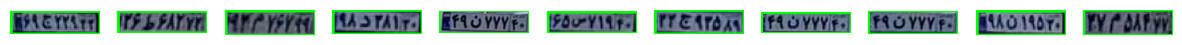

In [16]:
# Display license plate images using matplotlib
plate_images = [os.path.join(save_path, img) for img in os.listdir(save_path) if img.endswith('.png')]
plate_images = plate_images[:-1]
fig, axes = plt.subplots(1, len(plate_images), figsize=(15, 5))
for ax, img_path in zip(axes, plate_images):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img_rgb)
    ax.axis('off')
plt.show()

## Read CSV File
Read the CSV file containing the detected license plate data.


In [17]:
# Read the CSV file containing license plate data
df = pd.read_csv('license_plates.csv')
df

,Index,Time,License_plate
0,1,2024-07-04 12:18:17.073170,۱۶۹۲۱۹۹
1,2,2024-07-04 12:18:36.533838,۱۳۶ ۳۳
2,3,2024-07-04 12:18:51.678924,2۳2 ۳۵۹
3,4,2024-07-04 12:18:54.761435,|۳۸۷۰ خء ۸
4,5,2024-07-04 12:19:14.058203,۲۲۹ ۷۷۷۵
5,6,2024-07-04 12:19:24.338417,۷۶۶ص ۶۵|
6,7,2024-07-04 12:19:26.360980,۳۳ ۸۲
7,8,2024-07-04 12:19:28.915972,|۷۷۷۶ ن ۴۹
8,9,2024-07-04 12:19:31.032520,۴۹ 0 ۷۷۷۶۰
9,10,2024-07-04 12:19:42.740623,140 ۱۵۲۰
